In [1]:
from astral import LocationInfo
from astral.sun import sun
import datetime as dt
from pathlib import Path  
import pytz
from pytz import timezone
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import random
from random import sample
import re
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import median_test
from scipy.stats import shapiro
from scipy.stats import wilcoxon
import seaborn as sns
import statistics
from statsmodels.stats.diagnostic import lilliefors
import swifter
from swifter import set_defaults
import sys

In [2]:
# set swifter defaults
set_defaults(
    npartitions=None,
    dask_threshold=1,
    scheduler="processes",
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=False,
)

# set seaborn default theme figure size
sns.set_theme()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale = 2)

# Import Data

In [3]:
master = pd.read_csv('./data/hawaii_data/processed/master_hawaii.csv')

meta = pd.read_csv('./data/meta_data.csv')

In [4]:
master.info()
master

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794390 entries, 0 to 1794389
Data columns (total 19 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Unnamed: 0                     int64  
 1   Id                             int64  
 2   Datetime (UTC-10)              object 
 3   Hour (UTC-10)                  int64  
 4   Time of Day                    object 
 5   Depth(m)                       float64
 6   External Temp (c)              float64
 7   Sex                            object 
 8   Shark Length (cm)              float64
 9   Time of Day (Astral)           object 
 10  Depth Diff (m)                 float64
 11  Speed (m/s)                    float64
 12  Moon Phase                     object 
 13  Mean Hourly Depth (m)          float64
 14  Mean Hourly External Temp (c)  float64
 15  Vertical Velocity (m/s)        float64
 16  Mean Hourly Speed (m/s)        float64
 17  Hourly Diving Ratio            float64
 18  Da

,Unnamed: 0,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Vertical Velocity (m/s),Mean Hourly Speed (m/s),Hourly Diving Ratio,Daily SST Est (c)
0,0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,0.016667,New Moon,38.400000,24.600002,-0.016667,0.016667,1.0,24.75000
1,1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,0.025000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000
2,2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,0.033333,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000
3,3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,0.050000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000
4,4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,0.075000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794385,1794385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375
1794386,1794386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375
1794387,1794387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375
1794388,1794388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375


In [5]:
meta.info()
meta

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0.1            6 non-null      int64  
 1   Unnamed: 0              6 non-null      int64  
 2   eventid                 6 non-null      int64  
 3   tagnumber               6 non-null      object 
 4   ptt                     6 non-null      int64  
 5   taggingdate             6 non-null      object 
 6   length                  6 non-null      float64
 7   sex                     6 non-null      object 
 8   firstdate               6 non-null      object 
 9   lastdate                6 non-null      object 
 10  Sampling Period (sec)   6 non-null      int64  
 11  Max Depth Recorded (m)  6 non-null      float64
dtypes: float64(2), int64(5), object(5)
memory usage: 704.0+ bytes


,Unnamed: 0.1,Unnamed: 0,eventid,tagnumber,ptt,taggingdate,length,sex,firstdate,lastdate,Sampling Period (sec),Max Depth Recorded (m)
0,0,0,190000400,00P0291,29711,2000-10-16,457.00,M,01/03/2001 05:00,04/16/2001 05:00,120,612.0
1,1,1,190400900,04P0160,52933,2004-11-30,396.00,F,03/22/2005 05:00,06/10/2005 05:00,60,981.1
2,2,2,190502800,05P0132,62021,2005-12-15,480.00,F,03/31/2006 05:00,05/30/2006 05:00,60,549.1
3,3,3,190600200,05P0059,60983,2006-01-21,400.00,F,06/09/2006 05:00,09/03/2006 05:00,60,580.8
4,4,4,190601200,06A0555,68281,2006-10-10,426.72,M,02/09/2007 05:00,06/05/2007 05:00,15,691.5
5,5,5,190900200,08A0599,87568,2009-01-19,427.00,F,03/17/2009 05:00,06/09/2009 05:00,10,990.9


# 190000400

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


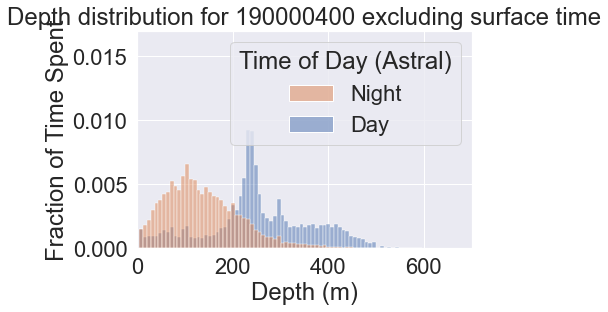

In [6]:
sh = master[master['Id'] == 190000400]

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]
filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False, palette = ['C1', 'C0'])
ax.set_ylim(0, 0.017)
ax.set_xlim(0, 700)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 excluding surface time')
plt.show()

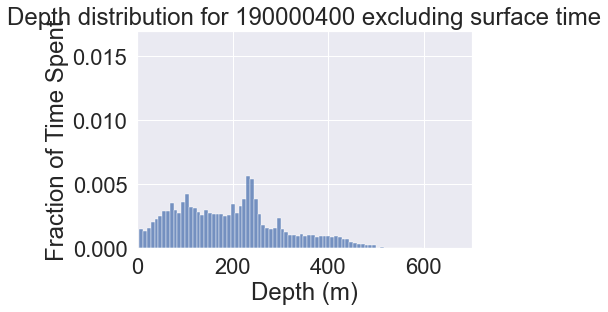

In [7]:
ax = sns.histplot(filtered, x="Depth(m)", stat="density", common_norm=False, palette = ['C1', 'C0'])
ax.set_ylim(0, 0.017)
ax.set_xlim(0, 700)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 excluding surface time')
plt.show()

In [8]:
day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']

In [9]:
statistics.median(day_depths['Depth(m)']), statistics.median(night_depths['Depth(m)'])

(244.2, 126.0)

In [10]:
# looking at lunar cycle night

full_night = night_depths[night_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_night = night_depths[night_depths['Moon Phase'] == 'New Moon']['Depth(m)']

full_day = day_depths[day_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_day = day_depths[day_depths['Moon Phase'] == 'New Moon']['Depth(m)']

resample_night = min(len(full_night), len(new_night)) - 1
resample_day = min(len(full_day), len(new_day))

len(full_night), len(new_night), resample_night

# patired t test to see if nighttime depth on full moon vs new moon is different
stat, p = stats.ttest_rel(sample(list(full_night), resample_night), sample(list(new_night), resample_night))

# patired t test to see if daytime depth on full moon vs new moon is different
stat2, p2 = stats.ttest_rel(sample(list(full_day), resample_day), sample(list(new_day), resample_day))

p, p2

(0.0049196245571323655, 3.7143561988859275e-19)

In [11]:
# looking at speed + diving ratio
speed_night = night_depths['Speed (m/s)']
speed_day = night_depths['Speed (m/s)']

ratio_night = day_depths['Hourly Diving Ratio']
ratio_day = day_depths['Hourly Diving Ratio']

resample_speed = min(len(speed_day), len(speed_night))
resample_ratio = min(len(ratio_day), len(ratio_night))

# patired t test to see if speed different night vs day
stat, p = stats.ttest_rel(sample(list(speed_night), resample_speed), sample(list(speed_day), resample_speed))

# patired t test to see if diving ratio different at night vs day
stat2, p2 = stats.ttest_rel(sample(list(ratio_night), resample_ratio), sample(list(ratio_day), resample_ratio))

# KS-test speed different night vs day
stat3, p3 = stats.kstest(speed_day, speed_night)

# KS-test ratio different night vs day
stat4, p4 = stats.kstest(ratio_night, ratio_day)


p, p2, p3, p4

(nan, nan, 1.0, 1.0)

# 190400900

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


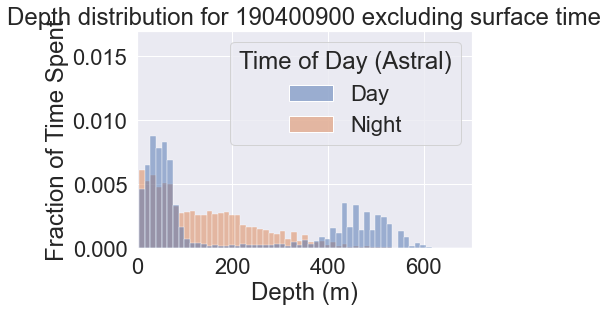

In [12]:
sh = master[master['Id'] == 190400900]

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]
filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190400900 excluding surface time')
plt.show()

In [13]:
day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']

In [14]:
statistics.median(day_depths['Depth(m)']), statistics.median(night_depths['Depth(m)'])

(74.5, 117.1)

In [15]:
day_depths_1 = day_depths[day_depths['Depth(m)'] < 200]['Depth(m)']
day_depths_2 = day_depths[day_depths['Depth(m)'] >= 200]['Depth(m)']

resample = min(len(day_depths_1), len(day_depths_2))

stat, p = stats.ttest_rel(sample(list(day_depths_1), resample), sample(list(day_depths_2), resample))

statistics.median(day_depths_1), statistics.median(day_depths_2), p

(48.9, 461.4, 0.0)

In [16]:
# looking at lunar cycle night

full_night = night_depths[night_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_night = night_depths[night_depths['Moon Phase'] == 'New Moon']['Depth(m)']

full_day = day_depths[day_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_day = day_depths[day_depths['Moon Phase'] == 'New Moon']['Depth(m)']

resample_night = min(len(full_night), len(new_night)) - 1
resample_day = min(len(full_day), len(new_day))

len(full_night), len(new_night), resample_night

# patired t test to see if nighttime depth on full moon vs new moon is different
stat, p = stats.ttest_rel(sample(list(full_night), resample_night), sample(list(new_night), resample_night))

# patired t test to see if daytime depth on full moon vs new moon is different
stat2, p2 = stats.ttest_rel(sample(list(full_day), resample_day), sample(list(new_day), resample_day))

p, p2

(2.4169170296662815e-40, 0.0)

# 190502800

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


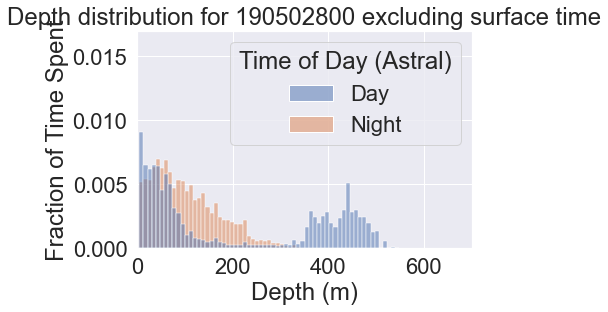

In [17]:
sh = master[master['Id'] == 190502800]

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]
filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190502800 excluding surface time')
plt.show()

In [18]:
day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']

In [19]:
statistics.median(day_depths['Depth(m)']), statistics.median(night_depths['Depth(m)'])

(100.0, 90.1)

In [20]:
day_depths_1 = day_depths[day_depths['Depth(m)'] < 200]['Depth(m)']
day_depths_2 = day_depths[day_depths['Depth(m)'] >= 200]['Depth(m)']

resample = min(len(day_depths_1), len(day_depths_2))

stat, p = stats.ttest_rel(sample(list(day_depths_1), resample), sample(list(day_depths_2), resample))

statistics.median(day_depths_1), statistics.median(day_depths_2), p

(45.0, 421.1, 0.0)

In [21]:
# looking at lunar cycle night

full_night = night_depths[night_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_night = night_depths[night_depths['Moon Phase'] == 'New Moon']['Depth(m)']

full_day = day_depths[day_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_day = day_depths[day_depths['Moon Phase'] == 'New Moon']['Depth(m)']

resample_night = min(len(full_night), len(new_night)) - 1
resample_day = min(len(full_day), len(new_day))

len(full_night), len(new_night), resample_night

# patired t test to see if nighttime depth on full moon vs new moon is different
stat, p = stats.ttest_rel(sample(list(full_night), resample_night), sample(list(new_night), resample_night))

# patired t test to see if daytime depth on full moon vs new moon is different
stat2, p2 = stats.ttest_rel(sample(list(full_day), resample_day), sample(list(new_day), resample_day))

p, p2

(1.496470022477368e-130, 3.950157732217884e-99)

# 190600200

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


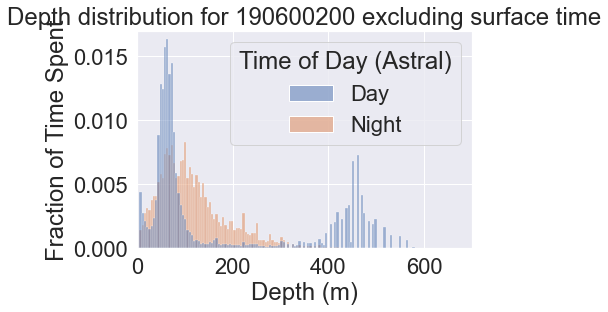

In [22]:
sh = master[master['Id'] == 190600200]

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]
filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190600200 excluding surface time')
plt.show()

In [23]:
day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']

In [24]:
statistics.median(day_depths['Depth(m)']), statistics.median(night_depths['Depth(m)'])

(72.6, 100.8)

In [25]:
day_depths_1 = day_depths[day_depths['Depth(m)'] < 200]['Depth(m)']
day_depths_2 = day_depths[day_depths['Depth(m)'] >= 200]['Depth(m)']

resample = min(len(day_depths_1), len(day_depths_2))

stat, p = stats.ttest_rel(sample(list(day_depths_1), resample), sample(list(day_depths_2), resample))

statistics.median(day_depths_1), statistics.median(day_depths_2), p

(62.8, 452.6, 0.0)

In [26]:
# looking at lunar cycle night

full_night = night_depths[night_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_night = night_depths[night_depths['Moon Phase'] == 'New Moon']['Depth(m)']

full_day = day_depths[day_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_day = day_depths[day_depths['Moon Phase'] == 'New Moon']['Depth(m)']

resample_night = min(len(full_night), len(new_night)) - 1
resample_day = min(len(full_day), len(new_day))

len(full_night), len(new_night), resample_night

# patired t test to see if nighttime depth on full moon vs new moon is different
stat, p = stats.ttest_rel(sample(list(full_night), resample_night), sample(list(new_night), resample_night))

# patired t test to see if daytime depth on full moon vs new moon is different
stat2, p2 = stats.ttest_rel(sample(list(full_day), resample_day), sample(list(new_day), resample_day))

p, p2

(1.1672664484948535e-37, 9.196749444669609e-05)

# 190601200

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


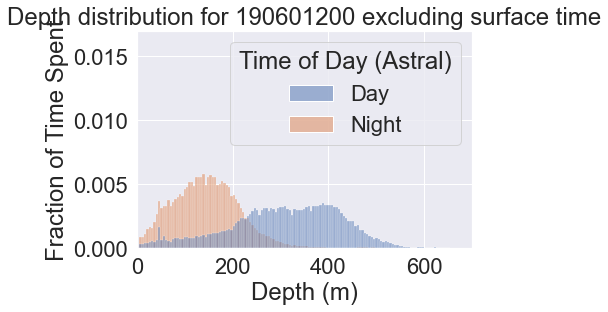

In [27]:
sh = master[master['Id'] == 190601200]

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]
filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190601200 excluding surface time')
plt.show()

In [28]:
day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']

In [29]:
statistics.median(day_depths['Depth(m)']), statistics.median(night_depths['Depth(m)'])

(316.8, 143.6)

In [30]:
# looking at lunar cycle night

full_night = night_depths[night_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_night = night_depths[night_depths['Moon Phase'] == 'New Moon']['Depth(m)']

full_day = day_depths[day_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_day = day_depths[day_depths['Moon Phase'] == 'New Moon']['Depth(m)']

resample_night = min(len(full_night), len(new_night)) - 1
resample_day = min(len(full_day), len(new_day))

len(full_night), len(new_night), resample_night

# patired t test to see if nighttime depth on full moon vs new moon is different
stat, p = stats.ttest_rel(sample(list(full_night), resample_night), sample(list(new_night), resample_night))

# patired t test to see if daytime depth on full moon vs new moon is different
stat2, p2 = stats.ttest_rel(sample(list(full_day), resample_day), sample(list(new_day), resample_day))

p, p2

(0.0, 0.0)

# 190900200

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


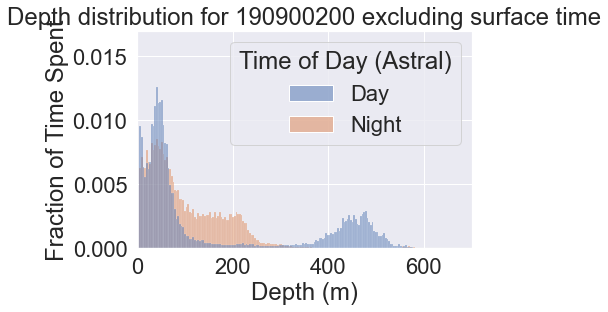

In [31]:
sh = master[master['Id'] == 190900200]

# filter out transition states (leaving only deep day or deep night)
filtered = sh.loc[(sh['Time of Day (Astral)'] == 'Day') | (sh['Time of Day (Astral)'] == 'Night')]
filtered = filtered[filtered['Depth(m)'] > 5]

ax = sns.histplot(filtered, x="Depth(m)", hue="Time of Day (Astral)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190900200 excluding surface time')
plt.show()

In [32]:
day_depths = filtered[filtered['Time of Day (Astral)'] == 'Day']
night_depths = filtered[filtered['Time of Day (Astral)'] == 'Night']

In [33]:
statistics.median(day_depths['Depth(m)']), statistics.median(night_depths['Depth(m)'])

(60.2, 74.9)

In [34]:
day_depths_1 = day_depths[day_depths['Depth(m)'] < 200]['Depth(m)']
day_depths_2 = day_depths[day_depths['Depth(m)'] >= 200]['Depth(m)']

resample = min(len(day_depths_1), len(day_depths_2))

stat, p = stats.ttest_rel(sample(list(day_depths_1), resample), sample(list(day_depths_2), resample))

statistics.median(day_depths_1), statistics.median(day_depths_2), p

(45.6, 448.3, 0.0)

In [35]:
# looking at lunar cycle night

full_night = night_depths[night_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_night = night_depths[night_depths['Moon Phase'] == 'New Moon']['Depth(m)']

full_day = day_depths[day_depths['Moon Phase'] == 'Full Moon']['Depth(m)']
new_day = day_depths[day_depths['Moon Phase'] == 'New Moon']['Depth(m)']

resample_night = min(len(full_night), len(new_night)) - 1
resample_day = min(len(full_day), len(new_day))

len(full_night), len(new_night), resample_night

# patired t test to see if nighttime depth on full moon vs new moon is different
stat, p = stats.ttest_rel(sample(list(full_night), resample_night), sample(list(new_night), resample_night))

# patired t test to see if daytime depth on full moon vs new moon is different
stat2, p2 = stats.ttest_rel(sample(list(full_day), resample_day), sample(list(new_day), resample_day))

p, p2

(1.825858657304663e-290, 0.0)

# Males vs. Females

In [36]:
def plotHeatMap(df, Id):
    # Apply the default theme
    sns.set_theme()
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set(font_scale = 2)
    
    binSize = 10
    maxDepth = 700
    bins = np.arange(0, maxDepth, binSize)
    df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])
    grouped = df.groupby(["Hour (UTC-10)", "Depth Bin"]).size().reset_index(name='count')
    grouped['percent'] = grouped['count'] / grouped.groupby("Hour (UTC-10)")['count'].transform('sum')
    piv = grouped.pivot("Depth Bin", "Hour (UTC-10)", "percent")
    ax = sns.heatmap(piv, robust=True, cbar_kws={'label': 'Fraction of Time Spent'})
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('Hour')
    ax.set_title('Time Spent at Depth for ' + Id)

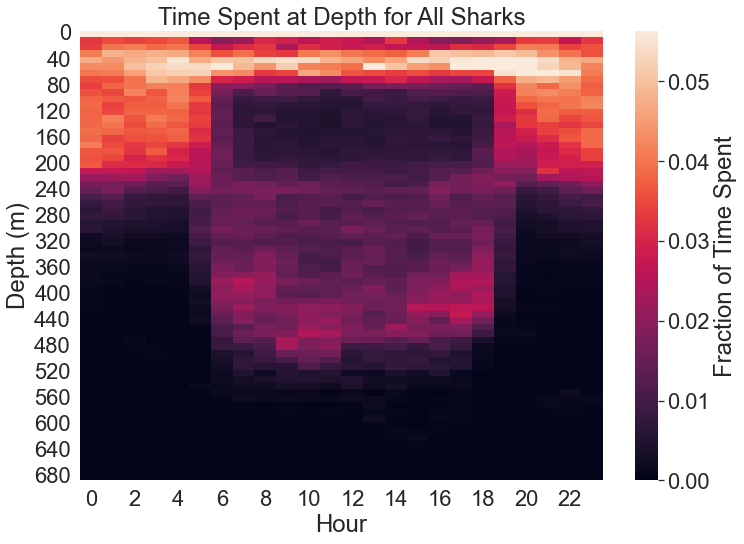

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_41968/1298990732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


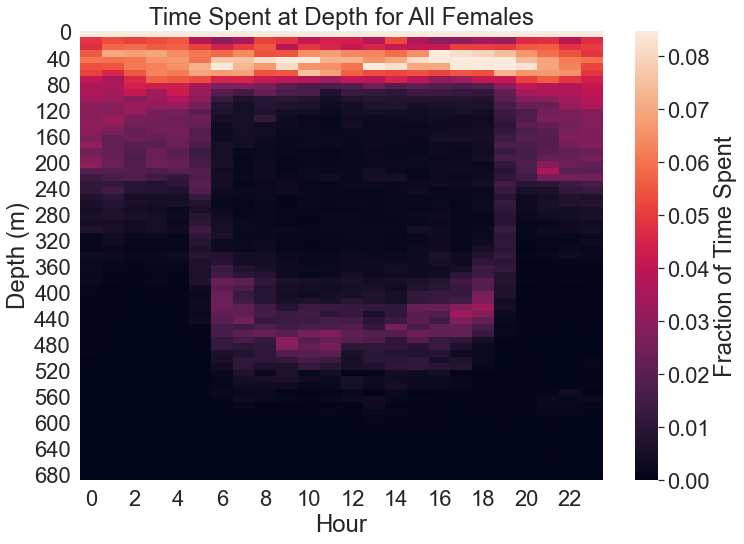

/var/folders/57/9723dmls3r5f8py4fcxpmz1r0000gp/T/ipykernel_41968/1298990732.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Depth Bin"] = pd.cut(df["Depth(m)"], bins=bins, labels=bins[:-1])


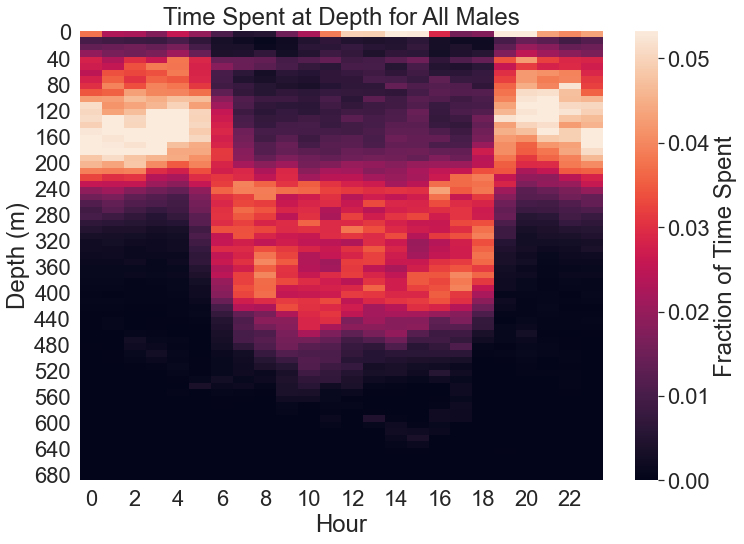

In [37]:
plotHeatMap(master, 'All Sharks')
plt.show()
plotHeatMap(master.loc[master['Sex'] == 'F'], 'All Females')
plt.show()
plotHeatMap(master.loc[master['Sex'] == 'M'], 'All Males')
plt.show()

In [38]:
master['Depth(m)'].mean(), np.std(master['Depth(m)'])

(160.77758937577667, 147.2637495150391)

# Stats for paper

In [39]:
archive_durations = np.array([182, 192, 299, 224, 241, 201]) # days
archive_durations.mean(), np.std(archive_durations)

(223.16666666666666, 39.214863961966714)

In [40]:
# days in caostal phase
coastal_days = np.array([35, 72, 112, 93, 83, 25])
coastal_days.mean(), np.std(coastal_days)

(70.0, 30.865298745786774)

In [41]:
ssm = pd.read_csv('./data/hawaii_data/ws_hawaiionly_ssm_archivals_2022apr12.csv')
ssm

,eventid,tagnumber,ptt,taggingdate,length,sex,latitude,longitude,month,year,date
0,190000400,00P0291,29711,2000-10-16,457.0,M,21.772190,-158.562114,1,2001,01/03/2001 05:00
1,190000400,00P0291,29711,2000-10-16,457.0,M,21.288875,-158.486529,1,2001,01/04/2001 05:00
2,190000400,00P0291,29711,2000-10-16,457.0,M,20.934433,-158.189378,1,2001,01/05/2001 05:00
3,190000400,00P0291,29711,2000-10-16,457.0,M,20.675729,-157.986978,1,2001,01/06/2001 05:00
4,190000400,00P0291,29711,2000-10-16,457.0,M,20.431531,-157.861104,1,2001,01/07/2001 05:00
...,...,...,...,...,...,...,...,...,...,...,...
460,190900200,08A0599,87568,2009-01-19,427.0,F,20.879899,-161.819905,5,2009,05/22/2009 05:00
461,190900200,08A0599,87568,2009-01-19,427.0,F,21.523138,-157.306133,5,2009,05/31/2009 05:00
462,190900200,08A0599,87568,2009-01-19,427.0,F,19.520476,-157.678366,6,2009,06/03/2009 05:00
463,190900200,08A0599,87568,2009-01-19,427.0,F,18.104369,-157.287156,6,2009,06/06/2009 05:00


In [42]:
# find how many days each id there

ssm['eventid'].value_counts()

190601200    108
190000400    104
190600200     87
190400900     81
190502800     58
190900200     27
Name: eventid, dtype: int64

In [43]:
days_spent_in_hawaii = np.array([27, 58, 81, 87, 104, 108])
days_spent_in_hawaii.mean(), np.std(days_spent_in_hawaii)

(77.5, 27.885181249784505)

In [44]:
ssm['month'].value_counts

<bound method IndexOpsMixin.value_counts of 0      1
1      1
2      1
3      1
4      1
      ..
460    5
461    5
462    6
463    6
464    6
Name: month, Length: 465, dtype: int64>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/swifter/swifter.py:83: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


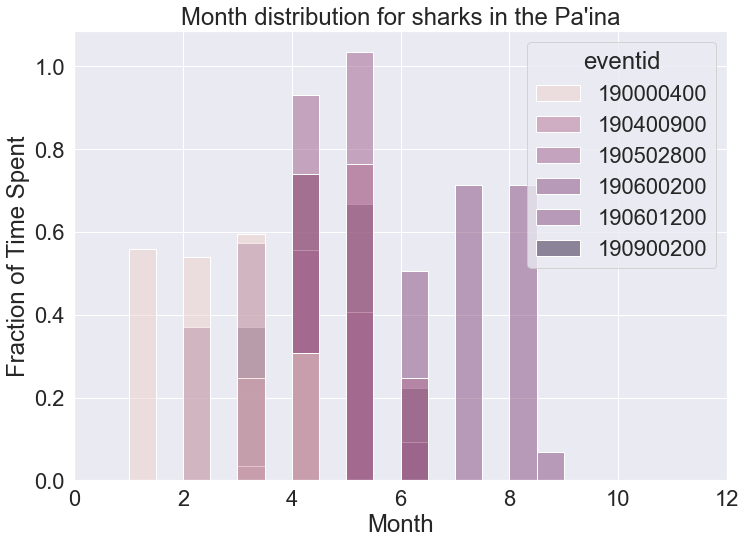

In [45]:
ax = sns.histplot(ssm, x="month", hue="eventid", stat="density", common_norm=False)
ax.set_xlim(0, 12)
# ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Month')
ax.set_title('Month distribution for sharks in the Pa\'ina')
plt.show()

In [46]:
ssm['month'].mean(), np.std(ssm['month'])

(4.30752688172043, 1.8485819359737765)

In [47]:
# median and igr for all sharks

q3, q1 = np.percentile(master['Depth(m)'], [75 ,25])
iqr = q3 - q1

statistics.median(master['Depth(m)']), iqr, q1, q3

(114.0, 210.0, 41.5, 251.5)

In [48]:
master['Id'].value_counts()

190900200    725760
190601200    673920
190600200    122400
190400900    113760
190502800     87840
190000400     70710
Name: Id, dtype: int64

# Eploring surface time

In [49]:
meta

,Unnamed: 0.1,Unnamed: 0,eventid,tagnumber,ptt,taggingdate,length,sex,firstdate,lastdate,Sampling Period (sec),Max Depth Recorded (m)
0,0,0,190000400,00P0291,29711,2000-10-16,457.00,M,01/03/2001 05:00,04/16/2001 05:00,120,612.0
1,1,1,190400900,04P0160,52933,2004-11-30,396.00,F,03/22/2005 05:00,06/10/2005 05:00,60,981.1
2,2,2,190502800,05P0132,62021,2005-12-15,480.00,F,03/31/2006 05:00,05/30/2006 05:00,60,549.1
3,3,3,190600200,05P0059,60983,2006-01-21,400.00,F,06/09/2006 05:00,09/03/2006 05:00,60,580.8
4,4,4,190601200,06A0555,68281,2006-10-10,426.72,M,02/09/2007 05:00,06/05/2007 05:00,15,691.5
5,5,5,190900200,08A0599,87568,2009-01-19,427.00,F,03/17/2009 05:00,06/09/2009 05:00,10,990.9


In [50]:
sh = master[master['Id'] == 190000400]
sh1 = master[master['Id'] == 190400900]
sh2 = master[master['Id'] == 190502800]
sh3 = master[master['Id'] == 190600200]
sh4 = master[master['Id'] == 190601200]
sh5 = master[master['Id'] == 190900200]

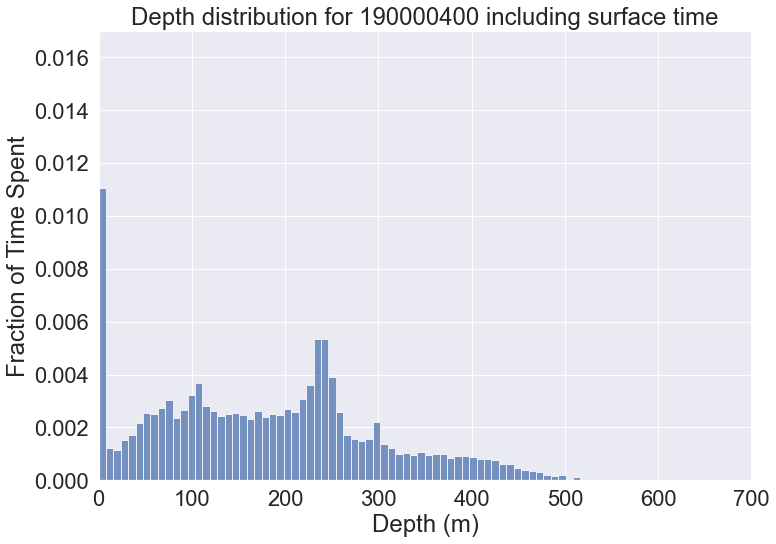

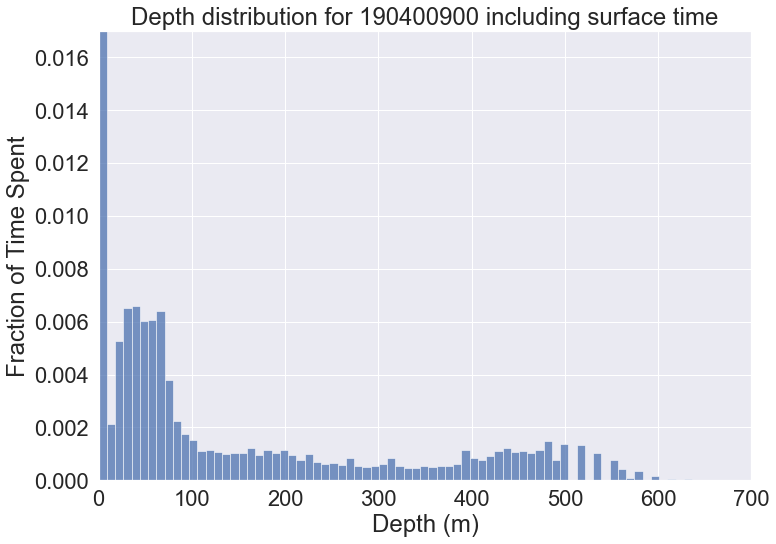

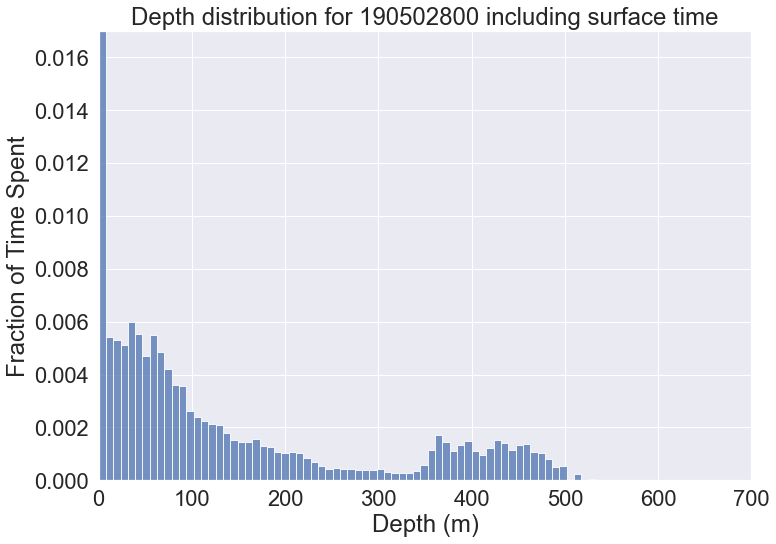

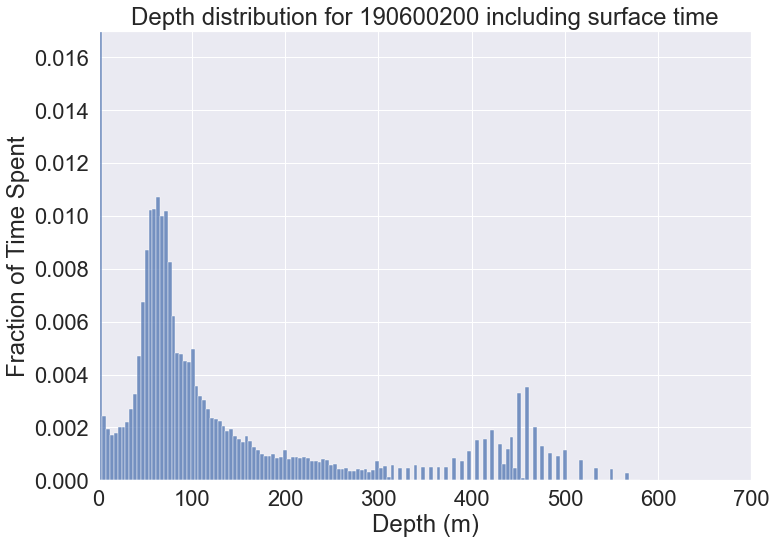

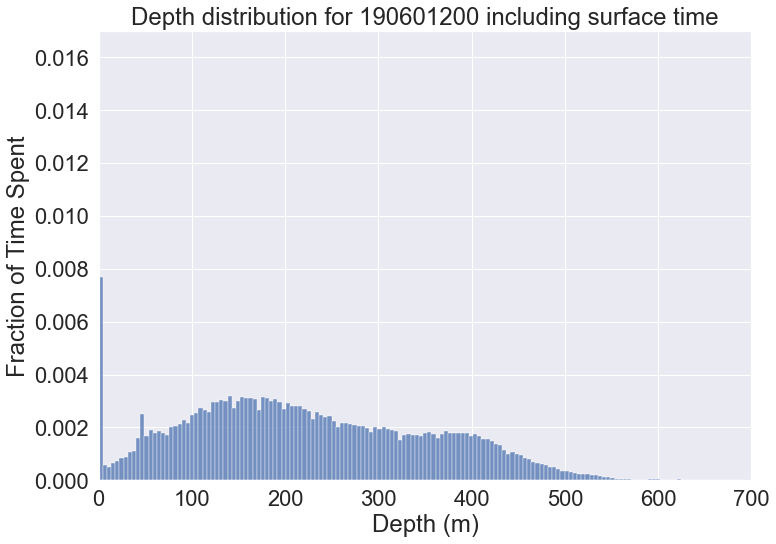

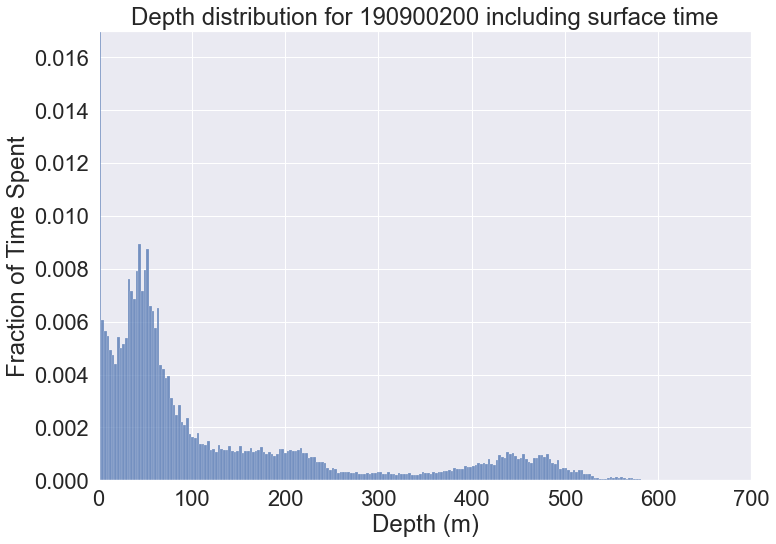

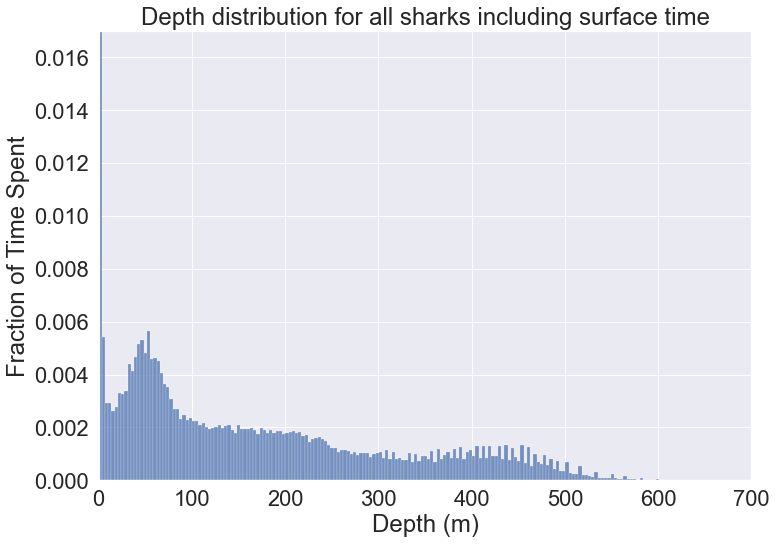

In [51]:
ax = sns.histplot(sh, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190000400 including surface time')
plt.show()

ax = sns.histplot(sh1, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190400900 including surface time')
plt.show()

ax = sns.histplot(sh2, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190502800 including surface time')
plt.show()

ax = sns.histplot(sh3, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190600200 including surface time')
plt.show()

ax = sns.histplot(sh4, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190601200 including surface time')
plt.show()

ax = sns.histplot(sh5, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for 190900200 including surface time')
plt.show()

ax = sns.histplot(master, x="Depth(m)", stat="density", common_norm=False)
ax.set_xlim(0, 700)
ax.set_ylim(0, 0.017)
ax.set_ylabel('Fraction of Time Spent')
ax.set_xlabel('Depth (m)')
ax.set_title('Depth distribution for all sharks including surface time')
plt.show()

In [52]:
# fraction of time spent in top 5 meters
len(master[(master['Depth(m)']  < 5)])/ len(master['Depth(m)']), np.std((master[(master['Depth(m)']  < 5)]))

(0.12271802673889178,
 Unnamed: 0                       520509.732605
 Id                               214344.030763
 Hour (UTC-10)                         5.951451
 Depth(m)                              1.099681
 External Temp (c)                     1.033033
 Shark Length (cm)                    16.179538
 Depth Diff (m)                        2.843673
 Speed (m/s)                           0.066212
 Mean Hourly Depth (m)                54.804640
 Mean Hourly External Temp (c)         1.956610
 Vertical Velocity (m/s)               0.035054
 Mean Hourly Speed (m/s)               0.082214
 Hourly Diving Ratio                   0.000000
 Daily SST Est (c)                     1.018164
 dtype: float64)

In [53]:
master

,Unnamed: 0,Id,Datetime (UTC-10),Hour (UTC-10),Time of Day,Depth(m),External Temp (c),Sex,Shark Length (cm),Time of Day (Astral),Depth Diff (m),Speed (m/s),Moon Phase,Mean Hourly Depth (m),Mean Hourly External Temp (c),Vertical Velocity (m/s),Mean Hourly Speed (m/s),Hourly Diving Ratio,Daily SST Est (c),Depth Bin
0,0,190000400,2001-01-02 18:59:50-10:00,18,Dusk,38.4,24.600002,M,457.0,Dusk,-2.0,0.016667,New Moon,38.400000,24.600002,-0.016667,0.016667,1.0,24.75000,30
1,1,190000400,2001-01-02 19:01:50-10:00,19,Night,40.4,24.600002,M,457.0,Dusk,-3.0,0.025000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000,40
2,2,190000400,2001-01-02 19:03:50-10:00,19,Night,43.4,24.600002,M,457.0,Dusk,-4.0,0.033333,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000,40
3,3,190000400,2001-01-02 19:05:50-10:00,19,Night,47.4,24.600002,M,457.0,Dusk,-6.0,0.050000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000,40
4,4,190000400,2001-01-02 19:07:50-10:00,19,Night,53.4,24.450001,M,457.0,Dusk,-9.0,0.075000,New Moon,77.166667,23.610001,-0.035000,0.056111,1.0,24.75000,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794385,1794385,190900200,2009-06-09 13:59:10-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375,400
1794386,1794386,190900200,2009-06-09 13:59:20-10:00,13,Day,405.3,8.700000,F,427.0,Day,-0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375,400
1794387,1794387,190900200,2009-06-09 13:59:30-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.0,0.000000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375,400
1794388,1794388,190900200,2009-06-09 13:59:40-10:00,13,Day,405.8,8.700000,F,427.0,Day,0.5,0.050000,Full Moon,412.559722,8.531944,0.000975,0.085376,1.0,25.14375,400


In [54]:
master['External Temp (c)'].mean()

19.100884526249576

In [55]:
master['Daily SST Est (c)'].mean()

24.50181441991296

In [56]:
master['Hourly Diving Ratio'].mean()

1.0

In [57]:
master['Speed (m/s)'].mean()

0.16897470106733004

In [58]:
master['Vertical Velocity (m/s)'].max(), master['Vertical Velocity (m/s)'].min()

(0.1613333333333333, -0.2272222222222222)

In [59]:
fem = master[master['Sex'] == 'F']
mal = master[master['Sex'] == 'M']

fem['Speed (m/s)'].mean(), mal['Speed (m/s)'].mean()

(0.08144897163404317, 0.29236605839873503)

<AxesSubplot:xlabel='Depth(m)', ylabel='Speed (m/s)'>

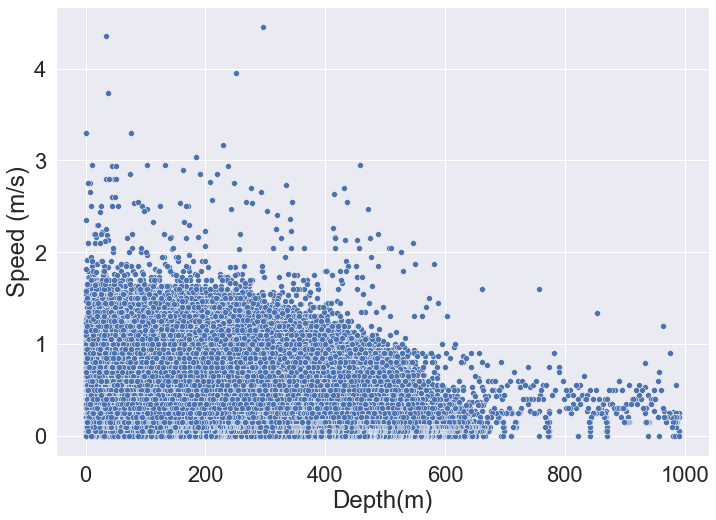

In [61]:
sns.scatterplot(data=master, x='Depth(m)', y='Speed (m/s)')